# Modelo SVM (Support Vector Machine)

Añadir todas las librerias necesarias para el entrenamiento y visualización de los datos.

In [ ]:
#Libreria que divide en test y train el dataset, permite usar Grid Search
#para revisar hiperparametros e incluye Stratified Kfold
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn import svm
from sklearn.svm import SVC
#Libreria para leer los archivos del dataset
import pandas as pd
#Calcular las metricas del modelo
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    roc_auc_score
)
#Visualizar las metricas del modelo
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_classification
#Libreria que nos permite guardar el modelo para correrlo sin necesidad de
#volver a entrenarlo
import pickle
#Libreria para manipular archivos
import os 
import sys

Cargar Dataset

In [ ]:
sys.path.append(os.path.abspath("../funciones"))
from funcionesEntrenamiento import (
    cargar_datos_entrenamiento,
    imprimir_forma,
    division_train_val,
    reporte_clasificacion,
    crear_matriz_confusion,
    calcular_roc_auc,
    metricas_tpr_fpr,
    hacer_pepinillo
)

In [ ]:
X, y = cargar_datos_entrenamiento()
shape, head = imprimir_forma(X)
print("Shape: ", shape)
head

In [ ]:
X_train, X_val, y_train, y_val = division_train_val(X, y)


print(f'Forma de conjunto de entrenamiento: {X_train.shape}')
print(f'Forma de conjunto de validacion: {X_val.shape}')

In [ ]:
y_pred, y_scores, reporte = reporte_clasificacion(X_val, y_val, SVM)

print("Classification Report:")
print(reporte)

In [ ]:
cm, disp = crear_matriz_confusion(y_val, y_pred)
disp.plot(cmap="RdPu")
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
# Predicciones de scores (para curva ROC)
fpr, tpr, thresholds, auc_score = calcular_roc_auc(y_val, y_scores)

# Gráfica de ROC
plt.plot(fpr, tpr, color='mediumorchid', label=f"Curva ROC (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], "k--", label='estimación aleatoria')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Cálculo de métricas de desempeño de la matriz de confusión
TPR, FPR = metricas_tpr_fpr(cm)

# Mostrar métricas
print(f"AUC: {(auc_score * 100):.4f}")
print(f"TPR (Tasa de Verdaderos Positivos): {(TPR * 100):.4f}")
print(f"FPR (Tasa de Falsos Positivos): {(FPR * 100):.4f}")

In [3]:
dataset = pd.read_csv('ds_tradicional.csv')
df = pd.DataFrame(dataset)

Dividir dataset, separando caracteristicas y etiquetas

In [4]:
df = pd.DataFrame(dataset)
y = df["class"]
x = df.drop(columns=["class"])  #No incluye la columna a clasificar

print("Shape x: ", x.shape)
x.head(5)

Shape x:  (1500, 1368)


,longitud_texto,num_palabras,comida,restriccion,purga,imagen_corporal,ejercicio,polaridad,subjetividad,tag_Anorexia,...,tfidf_1290,tfidf_1291,tfidf_1292,tfidf_1293,tfidf_1294,tfidf_1295,tfidf_1296,tfidf_1297,tfidf_1298,tfidf_1299
0,0.242191,-0.059671,0,0,0,0,0,1.173738,0.353420,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.549985,-1.624910,0,0,0,0,0,-0.336367,-1.128151,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.456454,-0.283276,3,2,0,0,0,0.796212,0.946048,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.333319,0.163935,0,0,0,1,0,1.777780,0.649734,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.790588,-0.730488,0,0,0,1,0,-1.317935,0.946048,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Generamos la separación del dataset para su validación; teniendo en cuenta que tenemos varios casos donde la etiqueta no será detección de problema mental usaremos stratify para mantener una proporcion adecuada en cada entrenamiento. Usando un split de 80 20 para train y test respectivamente y un random state de 22 el cual se mantendrá igual en cada uno.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2,
                                                    random_state=22,
                                                    stratify = y) # 80% training and 20% test

Creamos los hiperparametros objetivos para poder realizar el gridsearch, buscando el mejor para el entrenamiento.

In [6]:
#Elegimos que hiperparametros probar en el primer entrenamiento
hyperparam_grid = {
    'C': [0.1, 1, 10, 100, 400],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

Generamos un crossvalidation que use 5 splits y de esta manera poder generar un balance adecuado de clases.

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)

Guardamos el modelo svc en una variable con el mismo random state que previamente

In [8]:
model = SVC(random_state=22)

Iniciamos el Grid Search

* Usamos el modelo de svc para estimar durante el grid search.
* Con los hiperparametros elegidos realizamos el barrido.
* Usamos refit para ajustar el grid search al mejor valor posible durante entrenamiento.
* Con verbose = 3 podremos entender durante el entrenamiento como van cambiando los valores del mismo.
* La metrica a revisar será la area debajo de la curva para estimar cuales son los mejores hiperparametros para entrenar nuestro modelo.
* Con n_jobs = -1 nos permite usar todos los procesadores en paralelo, lo que permite un entrenamiento más rápido usando más recursos de la máquina.
* El cross validation que usaremos será con stratified kfolds, donde el objetivo será balancear el entrenamiento para que sea representativo de cada clase durante el entrenamiento.
* El error_score en raise nos va a arrojar errores si hay algun problema durante el entrenamiento, lo que nos ayuda al debug de errores en caso de que haya alguno.

In [9]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=hyperparam_grid,
    refit = True,
    verbose = 3,
    scoring = 'roc_auc',
    n_jobs=-1,
    cv = cv,
    error_score='raise'
)
grid_search.fit(X_test, y_test)

print(grid_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'C': 400, 'gamma': 0.001, 'kernel': 'rbf'}


Con los mejores valores de hiperparametros seleccionados, volvemos a realizar un barrido para encontrar algun valor que no hayamos considerado al momento de realizar el primer barrido.

In [10]:
#Elegimos que hiperparametros probar en el segundo entrenamiento
hyperparam_grid = {
    'C': [450, 500, 600, 800, 1000],
    'gamma': [0.001, 0.002, 0.004, 0.006, 0.008],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

In [11]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=hyperparam_grid,
    refit = True,
    verbose = 3,
    scoring = 'roc_auc',
    n_jobs=-1,
    cv = cv,
    error_score='raise'
)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'C': 450, 'gamma': 0.001, 'kernel': 'rbf'}


Realizamos un último barrido.

In [12]:
#Elegimos que hiperparametros probar en el ultimo entrenamiento
hyperparam_grid = {
    'C': [410, 420, 430, 440, 450],
    'gamma': [0.001, 0.012, 0.014, 0.016, 0.018],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

Usamos los valores obtenidos del grid search para realizar el entrenamiento con el modelo.

In [13]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=hyperparam_grid,
    refit = True,
    verbose = 3,
    scoring = 'roc_auc',
    n_jobs=-1,
    cv = cv,
    error_score='raise'
)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'C': 410, 'gamma': 0.001, 'kernel': 'rbf'}


Con los valores de los hiperparametros seleccionados creamos el modelo de SVM con los mejores.

In [14]:
SVM = SVC(C=450, gamma=0.001, kernel='rbf', probability=True)
SVM.fit(X_train, y_train)

SVC(C=450, gamma=0.001, probability=True)

Empezamos a predecir usando el modelo con el set de validación e imprimimos los resultados.

In [15]:
prediction = SVM.predict(X_test)
probability = SVM.predict_proba(X_test)[:, 1]

In [16]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       139
           1       0.87      0.89      0.88       161

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.87      0.87      0.87       300



Con los resultados generaremos una matriz de confusión para poder observar los Falsos Positivos, Verdaderos Positivos, Verdaderos Negativos y Falsos Negativos.

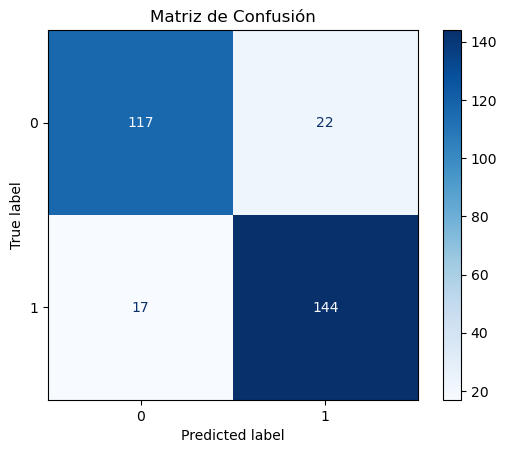

In [17]:
matrix = confusion_matrix(y_test, prediction)
display = ConfusionMatrixDisplay(matrix)
display.plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()

Graficamos la curva ROC para ??? al igual que imprimimos datos a partir de ello.

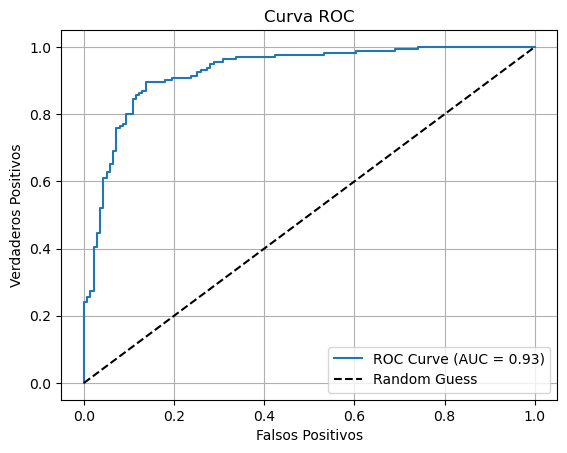

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, probability)
roc_auc_score = roc_auc_score(y_test, probability)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [19]:
false_positives = 28 / (28 + 111)
true_positives = 148 / (148 + 13)

print(f"Puntaje de Area Bajo la Curva: {(roc_auc_score * 100):.4f}%")
print(f"Puntaje de Falsos Positivos: {(false_positives * 100):.4f}%")
print(f"Puntaje de Verdaderos Positivos: {(true_positives * 100):.4f}%")

Puntaje de Area Bajo la Curva: 92.6315%
Puntaje de Falsos Positivos: 20.1439%
Puntaje de Verdaderos Positivos: 91.9255%


Una vez construido nuestro modelo, vamos a realizar el Entrenamiento y la Validación Final

In [ ]:
modelSVM = SVC(
          C=450, 
          gamma=0.001, 
          kernel='rbf', 
          probability=True
          )
modelSVM.fit(X_train, y_train)

Cargamos los datos nuevamente separando características y columna con las clases usando la función 

In [ ]:
X_test, y_test = cargar_datos_prueba()

shape_test, head_test = imprimir_forma(X_test)
print("Shape: ", shape_test)
head_test

Probamos nuestro modelo final e imprimimos las metricas

In [ ]:
#Prueba del modelo final
y_pred_test, y_scores_test, reporte_test = reporte_clasificacion(X_test, y_test, modelSVM, True)

print("Classification Report:")
print(reporte_test)

Creamos la Matriz de confusión final y lo graficamos

In [ ]:
cm_test, disp_test = crear_matriz_confusion(y_test, y_pred_test)

disp.plot(cmap="RdPu")
plt.title("Matriz de Confusión Final")
plt.show()

Realizamos el calculo de la probabilidad para la curva ROC y la graficamos

In [ ]:
fpr_test, tpr_test, thresholds_test, auc_score_test = calcular_roc_auc(y_test, y_scores_test)

plt.plot(fpr_test, tpr_test,color='mediumorchid', label=f"Curva ROC (AUC = {auc_score_test:.2f})")
plt.plot([0, 1], [0, 1], "k--", label='estimación aleatoria')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()


Realizamos el calculo de las metricas del desempeño del modelo usando una matriz de confusión, al igual que mostrar las metricas de AUC y tasa de Falsos Positivos y Verdaderos Positivos

In [ ]:
# Cálculo de métricas de desempeño de la matriz de confusión
TPR_Test, FPR_Test = metricas_tpr_fpr(cm_test)

# Mostrar métricas
print(f"AUC: {(auc_score_test * 100):.4f}")
print(f"TPR (Tasa de Verdaderos Positivos): {(TPR_Test * 100):.4f}")
print(f"FPR (Tasa de Falsos Positivos): {(FPR_Test * 100):.4f}")

Guardado del modelo final en un archivo pickle

In [ ]:
hacer_pepinillo(modelSVM, "modelPAC.pkl")